# Targeting Direct Marketing with Features Store and Amazon SageMaker XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## Contents

1. [Background](#Background)
1. [Prepration](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Exentsions](#Extensions)

---

## Background
Direct marketing, either through mail, email, phone, etc., is a common tactic to acquire customers.  Because resources and a customer's attention is limited, the goal is to only target the subset of prospects who are likely to engage with a specific offer.  Predicting those potential customers based on readily available information like demographics, past interactions, and environmental factors is a common machine learning problem.

This notebook presents an example problem to predict if a customer will enroll for a term deposit at a bank, after one or more phone calls.  The steps include:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
# cell 01
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
role

'arn:aws:iam::071908484098:role/service-role/AmazonSageMaker-ExecutionRole-20220319T153948'

Now let's bring in the Python libraries that we'll use throughout the analysis

In [2]:
# cell 02
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function上限函数
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

---

## Data
Let's start by downloading the [direct marketing dataset](https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip) from the sample data s3 bucket. 

\[Moro et al., 2014\] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


### Transformation

The transformations steps were made in DataWrangler & Features Store

**Get the data from FS**

In [3]:
# cell 03
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

# feature_group_name = "YOUR FEATURE GROUP NAME"
feature_group_name = "FG-option1-384396e0"

feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [4]:
# cell 04
# Build SQL query to features group
fs_query = feature_group.athena_query()
fs_table = fs_query.table_name
query_string = 'SELECT * FROM "'+fs_table+'"'
print('Running ' + query_string)

Running SELECT * FROM "fg-option1-384396e0-1647715651"


In [5]:
# cell 05
# Run Athena query. The output is loaded to a Pandas dataframe.
fs_query.run(query_string=query_string, output_location='s3://'+bucket+'/'+prefix+'/fs_query_results/')
fs_query.wait()
model_data = fs_query.as_dataframe()

In [6]:
# cell 06
model_data = model_data.drop(['fs_id', 'fs_time', 'write_time', 'api_invocation_time', 'is_deleted'], axis=1)

In [7]:
# cell 07
model_data

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin,job_blue-collar,job_technician,job_services,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,40,2,999,0,1,0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,1,0,1,0
1,32,2,999,0,1,0,0.0,0.0,0.0,1.0,...,0,1,0,0,0,0,1,0,1,0
2,55,2,999,0,1,0,0.0,1.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
3,47,3,999,0,1,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,1,0
4,54,27,999,0,1,0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,44,2,999,0,1,0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
41184,60,6,999,2,1,0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,1,0,0,1,0
41185,39,1,999,1,1,0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,1,0
41186,61,1,21,5,0,0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,1


When building a model whose primary goal is to predict a target value on new data, it is important to understand overfitting.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies特性 within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.

![image.png](https://miro.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png)

![image](https://www.researchgate.net/publication/334075368/figure/fig3/AS:774598614343680@1561690109206/The-bias-variance-dilemma-With-increased-model-complexity-ie-with-an-increased.ppm)

The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on "new" data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

![image](https://algotrading101.com/learn/wp-content/uploads/2020/05/training-validation-and-testing-split.png)
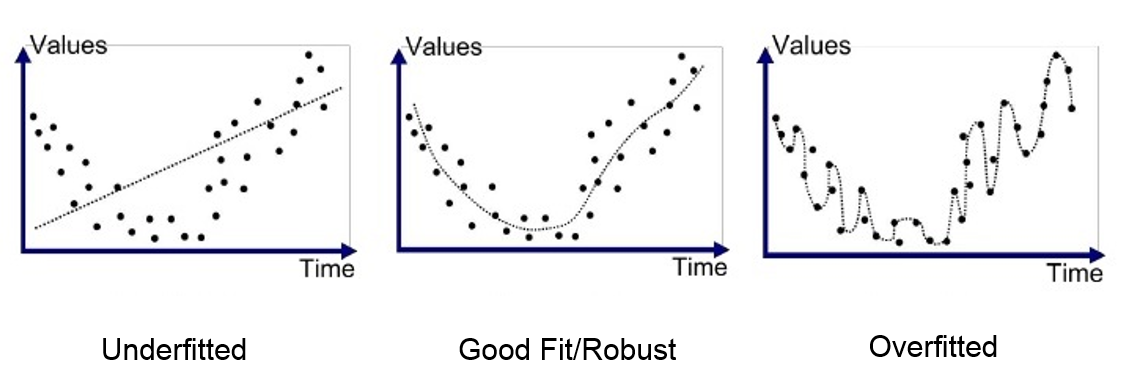

In [8]:
# cell 08
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [9]:
# cell 09
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [11]:
# cell 10
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---

## End of Lab 1


---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies错综复杂、难以理解 to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models. 

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

The training proceeds iteratively, adding new trees that predict the residuals or errors of prior trees that are then combined with previous trees to make the final prediction. It's called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

![image](https://docs.aws.amazon.com/zh_cn/sagemaker/latest/dg/images/xgboost_illustration.png)

https://docs.aws.amazon.com/zh_cn/sagemaker/latest/dg/xgboost-HowItWorks.html

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

https://github.com/aws/sagemaker-xgboost-container

In [13]:
# cell 11
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')
container

'685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [14]:
# cell 12
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies S3 location for output data.  In this case we have both a training and validation set which are passed in.

In [15]:
# cell 13
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

# XGBoost 超参数 - Amazon SageMaker
# https://docs.aws.amazon.com/zh_cn/sagemaker/latest/dg/xgboost_hyperparameters.html

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2022-03-19 20:04:53 Starting - Starting the training job...ProfilerReport-1647720293: InProgress
...
2022-03-19 20:05:37 Starting - Preparing the instances for training......
2022-03-19 20:06:43 Downloading - Downloading input data...
2022-03-19 20:07:17 Training - Downloading the training image...
2022-03-19 20:07:55 Uploading - Uploading generated training modelArguments: train
[2022-03-19:20:07:42:INFO] Running standalone xgboost training.
[2022-03-19:20:07:42:INFO] File size need to be processed in the node: 5.2mb. Available memory size in the node: 8525.46mb
[2022-03-19:20:07:42:INFO] Determined delimiter of CSV input is ','
[20:07:42] S3DistributionType set as FullyReplicated
[20:07:42] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-03-19:20:07:42:INFO] Determined delimiter of CSV input is ','
[20:07:42] S3DistributionType set as FullyReplicated
[20:07:42] 8238x59 matrix with 486042 entries loaded from /opt/ml

---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [16]:
# cell 14
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

------!

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the customer subscribed to a term deposit (`1`) or not (`0`), which produces a simple confusion matrix.

![image](https://i0.wp.com/www.ninenox.com/wp-content/uploads/2021/09/24-Figure2.1-1.png?resize=1024%2C368)

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

Serializers: Implements methods for serializing data for an inference endpoint.

https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html

![image](https://user-images.githubusercontent.com/48211034/74533329-39313100-4f29-11ea-82a5-7291792b2c3e.png)

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [17]:
# cell 15
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [18]:
# cell 16
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(), xgb_predictor)

Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [19]:
# cell 17
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,3622,41
1,361,95


So, of the ~4000 potential customers, we predicted 136 would subscribe and 94 of them actually did.  We also had 389 subscribers who subscribed that we did not predict would.  This is less than desirable, but the model can (and should) be tuned to improve this.  Most importantly, note that with minimal effort, our model produced accuracies similar to those published [here](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf).

_Note that because there is some element of randomness in the algorithm's subsample, your results may differ slightly from the text written above._

## Automatic model Tuning (optional)
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.
For example, suppose that you want to solve a binary classification problem on this marketing dataset. Your goal is to maximize the area under the curve (auc) metric of the algorithm by training an XGBoost Algorithm model. You don't know which values of the eta, alpha, min_child_weight, and max_depth hyperparameters to use to train the best model. To find the best values for these hyperparameters, you can specify ranges of values that Amazon SageMaker hyperparameter tuning searches to find the combination of values that results in the training job that performs the best as measured by the objective metric that you chose. Hyperparameter tuning launches training jobs that use hyperparameter values in the ranges that you specified, and returns the training job with highest auc.

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/2048px-Roc_curve.svg.png)

![image](https://new.pharmacelera.com/wp-content/uploads/2019/12/roc2.png)


In [20]:
# cell 18
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


In [21]:
# cell 19
objective_metric_name = 'validation:auc'

In [22]:
# cell 20
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)


In [23]:
# cell 21
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

.......................................................................................................................................................................................................................................................................................................!


In [24]:
# cell 22
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [25]:
# cell 23
# return the best training job name
tuner.best_training_job()

'xgboost-220319-2036-002-022040b0'

In [26]:
# cell 24
#  Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')


2022-03-19 20:39:35 Starting - Preparing the instances for training
2022-03-19 20:39:35 Downloading - Downloading input data
2022-03-19 20:39:35 Training - Training image download completed. Training in progress.
2022-03-19 20:39:35 Uploading - Uploading generated training model
2022-03-19 20:39:35 Completed - Training job completed
------!

In [27]:
# cell 25
# Create a serializer
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [28]:
# cell 26
# Predict
predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).to_numpy(),tuner_predictor)

In [29]:
# cell 27
# Collect predictions and convert from the CSV output our model provides into a NumPy array
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,3624,39
1,372,84


---

## Extensions

This example analyzed a relatively small dataset, but utilized Amazon SageMaker features such as distributed, managed training and real-time model hosting, which could easily be applied to much larger problems.  In order to improve predictive accuracy further, we could tweak value we threshold our predictions at to alter the mix of false-positives and false-negatives, or we could explore techniques like hyperparameter tuning.  In a real-world scenario, we would also spend more time engineering features by hand and would likely look for additional datasets to include which contain customer information not available in our initial dataset.

### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [30]:
# cell 28
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

In [31]:
# cell 29
tuner_predictor.delete_endpoint(delete_endpoint_config=True)